- Supervised
- New Data == Random Startpunkt
- Old Data == Augemnted mit 3 verschieden Startpunkten

In [24]:
from deepsudoku import REPO_PATH
import os
os.chdir(REPO_PATH)
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import tqdm
from deepsudoku.generate import Solver
from deepsudoku import DIFFICULTIES
import seaborn as sns

In [2]:
comp_our_data = pd.read_feather("data/comp_our_data.feather")
comp_old_data = pd.read_feather("data/comp_old_data.feather")

In [3]:
comp_old_data["missing"] = comp_old_data["quiz"].apply(lambda x: x.count("."))
comp_our_data["missing"] = comp_our_data["quiz"].apply(lambda x: x.count("."))

<Axes: xlabel='difficulty', ylabel='missing'>

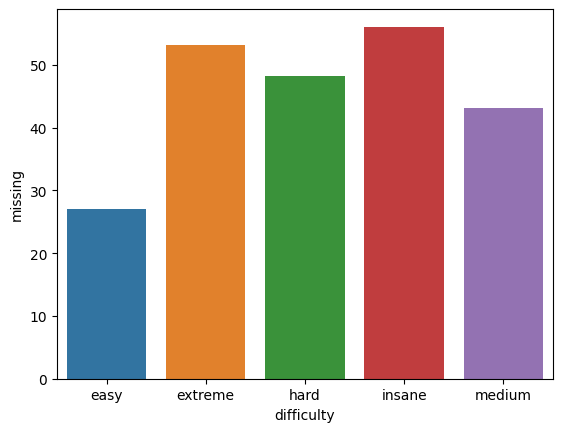

In [4]:
sns.barplot(comp_old_data, x ="difficulty", y = "missing")

<Axes: xlabel='difficulty', ylabel='missing'>

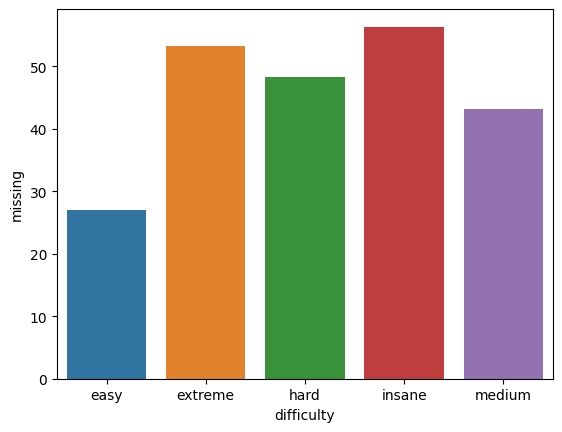

In [5]:
sns.barplot(comp_our_data, x ="difficulty", y = "missing")

In [6]:
comp_old_data[["quiz","solution"]].describe()

,quiz,solution
count,1350000,1350000
unique,1350000,671756
top,6..98.5.3.875.362451...49..87.24.356.56..924.2...,2678431955912764388345197626723845199156278433...
freq,1,10


In [7]:
comp_our_data[["quiz","solution"]].describe()

,quiz,solution
count,1350000,1350000
unique,1350000,1350000
top,.3..8964148.576.39.29.1387.197652.8.5...9.1268...,7352896414815762396294138751976524835438971268...
freq,1,1


In [8]:
old_logs = pd.read_csv("logs/comp_old_data/logs.csv")
our_logs = pd.read_csv("logs/comp_our_data/logs.csv")

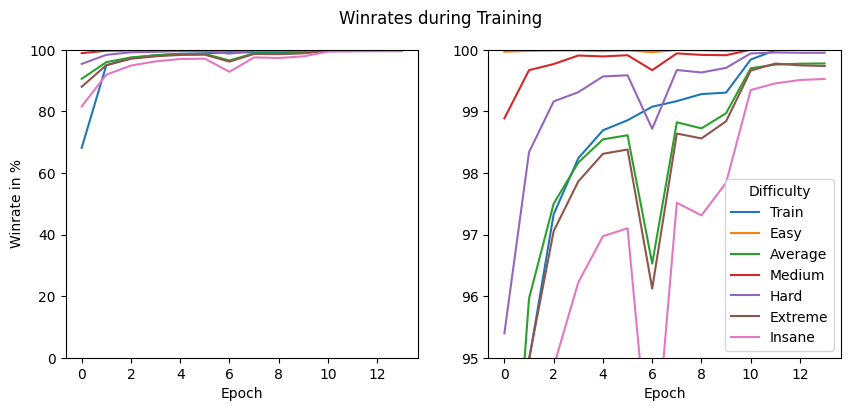

In [33]:
def preprocess_df(df):
    
    df = df.rename(columns= {"sudoku_win_rate": "sudoku_win_rate/train"})

    val_win_rates = [i for i in df.columns if "win_rate" in i]

    df = df[["epoch",] + val_win_rates]

    df = df.rename(columns= {i: i[i.find('/')+1:] for i in val_win_rates})
    
    df = df.rename(columns= {"val_sudoku_win_rate" : "Average"})
    
    df.columns = [i.title() for i in df.columns]
    df_melt = df.melt('Epoch', var_name='Difficulty', value_name='Winrate')

    @np.vectorize
    def sort_func(i):
        
        if i.lower() == "train":
            return 0
        
        if i.lower() == "average":
            return 2
        
        return DIFFICULTIES.index(i.lower()) + 2

    df_melt = df_melt.sort_values("Difficulty", key = sort_func)
    df_melt.Winrate *= 100

    
    return df_melt

old_values = preprocess_df(old_logs)
old_values["Data"] = "Augmented"
new_values = preprocess_df(our_logs)
new_values["Data"] = "Random"

together = pd.concat((new_values, old_values))

plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2,1)
sns.lineplot(data=old_values, x="Epoch", y="Winrate", hue="Difficulty", legend= None)
plt.ylim(0, 100)
plt.ylabel("Winrate in %")
# Plotting with y-axis limits from 0.95 to 1
ax = plt.subplot(1, 2,2)
sns.lineplot(data=old_values, x="Epoch", y="Winrate", hue="Difficulty")
plt.ylim(95, 100)
plt.ylabel(None)
plt.suptitle("Winrates during Training")
plt.show()

/home/felix/anaconda3/envs/sudoku/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_13435/3460704641.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


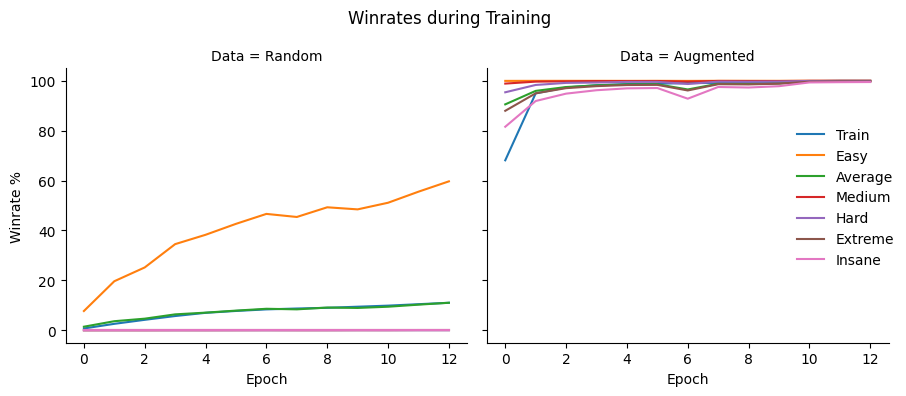

In [46]:
grid = sns.FacetGrid(together.query("Epoch < 13"), col = "Data", height = 4)
grid.map_dataframe(sns.lineplot, x="Epoch", y="Winrate", hue="Difficulty")
grid.add_legend()
grid.axes[0,0].set_ylabel("Winrate %")
plt.suptitle("Winrates during Training")
plt.tight_layout()